In [1]:
# Import Libraries
from keras.models import Sequential, clone_model, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import concatenate
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1)/255
X_test = X_test.reshape(X_test.shape[0], -1)/255

X_train = X_train[y_train == 0]
X_test = X_test[y_test == 0]
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
y_train = y_train[y_train == 0]
y_test = y_test[y_test == 0]

In [3]:
def baseline_model(num_pixels, num_classes):
    inpt1 = Input(shape=(num_pixels,))
    dense1 = Dense(num_pixels,kernel_initializer='normal',activation='relu')(inpt1)
    
    inpt2 = Input(shape=(num_pixels,))
    dense2 = Dense(num_pixels,kernel_initializer='normal',activation='relu')(inpt2)
    
    concat_layer = concatenate([dense1, dense2], axis=-1)
    logits = Dense(num_classes, kernel_initializer='normal',activation='softmax')(concat_layer)
    model = Model([inpt1, inpt2], logits)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
num_pixels = X_train.shape[1]
num_classes = 2

model_D = baseline_model(num_pixels=num_pixels, num_classes=num_classes)

In [5]:
model_D.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          615440      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          615440      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [6]:
def generator_model(input_dimension, hidden_size, discriminator):
    inpt1 = Input(shape=input_dimension)
    l = inpt1
    for hid in hidden_size:
        l = Dense(units=hid, kernel_initializer='normal',activation='relu')(l)
    model_d = clone_model(model=discriminator)
    for layer in model_d.layers:
        layer.trainable = False
        
    inpt2 = Input(shape=(784,))
    out = model_d([l, inpt2])
    model_gan = Model([inpt1, inpt2], out)
    model_gan.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    model_G = Model(inpt1, l)
    return model_gan, model_G

In [44]:
num_pixels = X_train.shape[1]
num_classes = 2

model_D = baseline_model(num_pixels=num_pixels, num_classes=num_classes)
model_GAN, model_G = generator_model((100,), [32, 784], model_D)
for e in range(100):
    print("Epoch: {}".format(e))
    Noise_x = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], 100))
    fake_image = model_G.predict(Noise_x)
    X_train_sync = np.concatenate([fake_image, X_train], axis=0)
    y_train_sync = np_utils.to_categorical(np.array([0]*fake_image.shape[0] + [1] * X_train.shape[0]))

    idx = np.random.choice(np.arange(X_train.shape[0]), replace=False, size=X_train.shape[0])
    X_train_ori = np.concatenate([X_train, X_train[idx]], axis=0)
    
    idx = np.random.choice(np.arange(X_train_sync.shape[0]), replace=False, size=X_train_sync.shape[0])
    X_train_sync = X_train_sync[idx, :]
    X_train_ori =  X_train_ori[idx, :]
    
    y_train_sync = y_train_sync[idx, :]
    
    for _ in range(10):
        for i in range(0, X_train_sync.shape[0], 64):
            loss, acc = model_D.train_on_batch(x=[X_train_sync[i:i + 64,:], X_train_ori[i:i+64, :]], y=y_train_sync[i:i+64])
            print(acc, end=", ")
    print()
    model_GAN.layers[4].set_weights(model_D.get_weights())

    for i in np.random.choice(range(0, Noise_x.shape[0], 64), replace=False, size=30):
        loss, acc = model_GAN.train_on_batch(x = [Noise_x[i:i+64,:], X_train[i:i+64,:]], y=np.array([[0,1]]*Noise_x[i:i+64,:].shape[0]))
        print(acc, end=", ")
    print()
    
    

Epoch: 0
0.40625, 0.5, 0.75, 1.0, 0.9375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.59375, 0.90625, 0.59375, 0.734375, 0.96875, 0.828125, 0.765625, 0.65625, 0.984375, 1.0, 1.0, 0.953125, 0.875, 0.9375, 0.953125, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.46875, 0.5, 0.421875, 0.625, 0.609375, 0.703125, 0.78125, 0.796875, 0.796875, 0.84375, 0.875, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.96875, 1.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.46875, 0.46875, 0.5625, 0.90625, 0.671875, 0.734375, 0.75, 0.78125, 0.734375, 0.890625, 0.921875, 0.734375, 0.703125, 0.796875, 0.953125, 0.96875, 0.96875, 0.875, 0.921875, 0.890625, 0.953125, 0.96875, 0.890625, 0.9375, 0.953125, 0.9375, 1.0, 0.96875, 0.96875, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 0.96875, 0.96875, 1.0, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.953125, 1.0, 0.984375, 0.96875, 0.953125, 1.0, 0.96875, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.53125, 0.515625, 0.921875, 0.921875, 0.90625, 0.828125, 0.9375, 0.859375, 0.921875, 0.984375, 0.984375, 0.890625, 0.9375, 0.9375, 1.0, 0.875, 0.8125, 0.984375, 0.96875, 0.953125, 0.953125, 0.953125, 0.984375, 0.921875, 0.921875, 0.984375, 0.984375, 0.953125, 1.0, 0.9375, 0.953125, 0.96875, 0.96875, 0.984375, 1.0, 0.9375, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.921875, 0.96875, 0.96875, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.921875, 0.953125, 0.984375, 0.96875, 1.0, 0.984375, 0.90625, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.953125, 0.953125, 0.984375, 0.984375, 1.0, 0.96875, 0.96875, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5625, 0.53125, 0.953125, 0.96875, 0.890625, 0.96875, 0.953125, 0.890625, 0.90625, 0.953125, 0.859375, 0.875, 0.921875, 0.96875, 0.9375, 0.953125, 0.921875, 0.90625, 0.984375, 0.953125, 0.984375, 0.953125, 0.953125, 0.953125, 0.921875, 0.96875, 0.96875, 0.984375, 1.0, 0.984375, 0.96875, 0.953125, 1.0, 0.984375, 0.984375, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.953125, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 0.9375, 1.0, 0.96875, 0.953125, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.5625, 0.546875, 0.9375, 0.984375, 0.96875, 0.9375, 0.921875, 0.921875, 0.890625, 0.90625, 0.8125, 0.90625, 0.890625, 0.90625, 0.96875, 0.984375, 0.96875, 0.953125, 0.96875, 0.984375, 1.0, 1.0, 0.90625, 0.9375, 0.953125, 0.96875, 0.9375, 0.9375, 0.984375, 0.96875, 0.953125, 0.984375, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.96875, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.953125, 1.0, 0.984375, 0.984375, 0.953125, 0.984375, 1.0, 0.9375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 0.953125, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5625, 0.53125, 0.96875, 1.0, 0.984375, 0.9375, 0.9375, 0.9375, 0.921875, 0.90625, 0.84375, 0.875, 0.890625, 0.953125, 0.953125, 0.90625, 0.921875, 0.96875, 0.96875, 0.9375, 0.953125, 0.96875, 0.953125, 1.0, 0.953125, 0.984375, 0.984375, 0.984375, 0.953125, 0.90625, 1.0, 0.890625, 0.9375, 0.984375, 0.984375, 1.0, 0.96875, 0.9375, 1.0, 0.96875, 0.984375, 0.96875, 0.96875, 1.0, 0.96875, 1.0, 0.96875, 1.0, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.953125, 0.953125, 1.0, 1.0, 0.953125, 0.984375, 0.984375, 1.0, 0.984375, 0.9375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5, 0.640625, 0.734375, 1.0, 0.953125, 0.953125, 0.921875, 0.9375, 0.84375, 0.921875, 0.859375, 0.9375, 0.953125, 0.96875, 0.96875, 0.96875, 0.9375, 0.984375, 0.9375, 0.984375, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 0.9375, 0.9375, 0.984375, 0.96875, 0.984375, 1.0, 0.953125, 1.0, 1.0, 1.0, 0.96875, 0.953125, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.9375, 0.953125, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.9375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.96875, 0.953125, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.953125, 1.0, 0.953125, 0.96875, 0.953125, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.953125, 1.0, 0.984375, 1.0, 0.953125, 1.0, 0.96875, 0.984375, 0.953125, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.9

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.53125, 0.453125, 0.90625, 0.953125, 0.96875, 0.953125, 0.984375, 0.9375, 0.9375, 0.890625, 0.921875, 0.953125, 0.875, 0.953125, 0.953125, 0.921875, 0.921875, 0.953125, 0.9375, 0.953125, 0.9375, 0.953125, 0.921875, 0.921875, 0.9375, 0.984375, 1.0, 0.984375, 0.96875, 0.96875, 0.9375, 0.984375, 0.96875, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.953125, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.96875, 1.0,

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.46875, 0.46875, 0.65625, 0.953125, 0.96875, 0.953125, 0.921875, 0.953125, 0.90625, 0.921875, 0.921875, 0.953125, 0.875, 0.875, 0.953125, 0.90625, 0.96875, 0.90625, 0.9375, 0.96875, 0.9375, 0.90625, 0.96875, 0.984375, 0.9375, 0.953125, 0.90625, 0.890625, 0.953125, 0.984375, 0.921875, 0.96875, 1.0, 0.96875, 0.9375, 0.953125, 0.96875, 0.984375, 0.984375, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.953125, 0.984375, 0.984375, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.953125, 1.0, 0.953125, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.9375, 0.984375, 1.0, 0.921875, 0.953125, 1.0, 0.953125, 1.0, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.46875, 0.59375, 0.53125, 0.984375, 0.96875, 0.953125, 0.9375, 0.953125, 0.953125, 0.953125, 0.921875, 0.921875, 0.96875, 0.96875, 0.953125, 0.921875, 0.859375, 0.953125, 0.921875, 0.90625, 0.953125, 0.921875, 0.9375, 0.953125, 0.921875, 0.953125, 0.9375, 0.9375, 0.96875, 0.890625, 0.9375, 0.953125, 0.953125, 0.984375, 0.96875, 0.953125, 0.96875, 0.984375, 0.984375, 0.984375, 0.953125, 1.0, 0.984375, 0.96875, 0.984375, 0.953125, 0.984375, 0.96875, 0.96875, 0.96875, 1.0, 1.0, 0.9375, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 1.0, 0.9375, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.96875, 1.0, 0.953125, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.96875, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.98

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.5625, 0.640625, 0.40625, 0.734375, 0.84375, 0.984375, 0.90625, 0.96875, 0.96875, 0.890625, 0.921875, 0.9375, 0.9375, 0.921875, 0.921875, 0.875, 0.84375, 0.890625, 0.875, 0.921875, 0.859375, 0.890625, 0.9375, 0.875, 0.9375, 0.90625, 0.96875, 0.953125, 0.96875, 0.921875, 0.9375, 0.9375, 0.9375, 0.921875, 0.859375, 0.890625, 0.9375, 0.96875, 0.953125, 0.984375, 0.984375, 0.953125, 0.96875, 0.984375, 0.984375, 0.96875, 0.953125, 0.9375, 1.0, 0.984375, 0.921875, 0.984375, 0.96875, 0.953125, 0.96875, 0.953125, 0.984375, 0.921875, 1.0, 0.9375, 0.984375, 0.96875, 0.984375, 0.984375, 0.953125, 0.90625, 0.90625, 0.921875, 0.96875, 0.953125, 0.984375, 0.96875, 0.984375, 0.96875, 0.953125, 0.96875, 0.984375, 0.953125, 0.984375, 0.96875, 0.953125, 1.0, 0.984375, 0.984375, 0.96875, 0.921875, 0.984375, 0.9375, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 1.0, 0.9375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 0.96875, 0.93

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.53125, 0.40625, 0.453125, 0.5, 0.671875, 0.796875, 0.890625, 0.90625, 0.953125, 0.8125, 0.796875, 0.890625, 0.78125, 0.84375, 0.875, 0.9375, 0.859375, 0.8125, 0.890625, 0.90625, 0.921875, 0.90625, 0.875, 0.875, 0.921875, 0.90625, 0.90625, 0.890625, 0.953125, 0.875, 0.921875, 0.890625, 0.84375, 1.0, 0.875, 0.953125, 0.90625, 0.875, 0.9375, 0.921875, 0.921875, 0.90625, 0.96875, 0.9375, 0.96875, 0.953125, 0.953125, 0.890625, 0.984375, 0.9375, 0.9375, 0.96875, 0.953125, 0.9375, 0.953125, 0.9375, 0.921875, 0.953125, 0.890625, 0.890625, 0.953125, 0.953125, 1.0, 0.984375, 0.984375, 0.90625, 0.96875, 0.953125, 0.984375, 0.984375, 0.96875, 0.953125, 0.984375, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.90625, 0.953125, 0.953125, 0.984375, 0.984375, 0.96875, 0.953125, 0.9375, 1.0, 0.984375, 0.9375, 0.984375, 0.984375, 0.890625, 1.0, 0.9375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.609375, 0.5, 0.5, 0.578125, 0.5, 0.4375, 0.46875, 0.65625, 0.59375, 0.578125, 0.71875, 0.890625, 0.84375, 0.953125, 0.875, 0.984375, 0.8125, 0.890625, 0.875, 0.796875, 0.828125, 0.796875, 0.890625, 0.875, 0.921875, 0.90625, 0.9375, 0.90625, 0.9375, 0.96875, 0.953125, 0.921875, 0.96875, 0.953125, 0.953125, 0.9375, 0.96875, 0.921875, 0.953125, 0.953125, 0.921875, 0.953125, 0.984375, 0.984375, 0.984375, 0.953125, 0.9375, 0.96875, 0.9375, 0.984375, 0.96875, 0.890625, 0.9375, 0.984375, 0.90625, 0.984375, 1.0, 0.9375, 1.0, 0.953125, 0.96875, 0.9375, 0.953125, 0.96875, 0.984375, 0.984375, 0.921875, 0.984375, 0.9375, 0.953125, 0.90625, 0.96875, 0.96875, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 0.953125, 0.984375, 1.0, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.953125, 0.953125, 0.96875, 0.984375, 0.96875, 0.96875, 0.984375, 0.953125, 0.96875, 1.0, 0.96875, 1.0, 0.953125, 0.984375, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375,

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.71875, 0.71875, 0.703125, 0.859375, 0.953125, 0.921875, 0.90625, 0.84375, 0.953125, 0.90625, 0.90625, 0.859375, 0.953125, 0.90625, 0.875, 0.953125, 0.984375, 0.953125, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.953125, 0.984375, 1.0, 0.953125, 0.953125, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.765625, 0.84375, 0.875, 0.84375, 0.90625, 0.9375, 0.875, 0.953125, 0.875, 0.890625, 0.890625, 0.859375, 0.953125, 0.921875, 0.9375, 0.921875, 0.9375, 0.96875, 0.96875, 0.9375, 0.96875, 0.96875, 0.921875, 0.96875, 0.921875, 0.9375, 0.890625, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.984375, 0.953125, 1.0, 0.953125, 1.0, 0.96875, 1.0, 0.984375, 0.953125, 0.96875, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.953125, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.578125, 0.5625, 0.609375, 0.625, 0.734375, 0.9375, 0.875, 0.921875, 0.921875, 0.84375, 0.828125, 0.875, 0.953125, 0.796875, 0.921875, 0.90625, 0.890625, 0.953125, 0.96875, 0.96875, 0.921875, 0.90625, 0.890625, 0.90625, 0.984375, 0.96875, 0.984375, 0.96875, 0.921875, 0.96875, 0.96875, 0.9375, 1.0, 0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.953125, 0.984375, 0.96875, 0.953125, 0.953125, 0.921875, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.953125, 0.984375, 0.96875, 1.0, 0.96875, 0.96875, 0.96875, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.5625, 0.40625, 0.625, 0.453125, 0.5, 0.484375, 0.4375, 0.421875, 0.5625, 0.65625, 0.71875, 0.6875, 0.734375, 0.828125, 0.890625, 0.78125, 0.8125, 0.734375, 0.859375, 0.859375, 0.796875, 0.78125, 0.78125, 0.828125, 0.765625, 0.796875, 0.78125, 0.90625, 0.875, 0.9375, 0.8125, 0.875, 0.890625, 0.875, 0.9375, 0.96875, 0.875, 0.9375, 0.90625, 0.890625, 0.84375, 0.890625, 0.96875, 0.875, 0.953125, 0.90625, 0.890625, 0.890625, 0.875, 0.875, 0.921875, 0.953125, 0.984375, 0.890625, 0.9375, 0.890625, 0.9375, 0.984375, 0.9375, 0.921875, 0.9375, 0.96875, 0.96875, 0.984375, 0.953125, 1.0, 0.9375, 1.0, 0.96875, 0.921875, 0.984375, 0.921875, 0.96875, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.953125, 0.984375, 0.984375, 0.96875, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.98437

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.421875, 0.546875, 0.46875, 0.5, 0.578125, 0.515625, 0.453125, 0.609375, 0.859375, 0.75, 0.84375, 0.890625, 0.875, 0.84375, 0.8125, 0.765625, 0.796875, 0.875, 0.828125, 0.828125, 0.875, 0.90625, 0.9375, 0.9375, 0.90625, 0.921875, 0.859375, 0.890625, 0.890625, 0.953125, 0.859375, 0.953125, 0.9375, 0.921875, 0.984375, 0.921875, 0.859375, 0.96875, 0.90625, 1.0, 0.96875, 0.96875, 0.953125, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.9375, 0.953125, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.484375, 0.578125, 0.625, 0.484375, 0.515625, 0.46875, 0.515625, 0.546875, 0.5625, 0.421875, 0.40625, 0.625, 0.59375, 0.640625, 0.671875, 0.703125, 0.828125, 0.796875, 0.8125, 0.796875, 0.8125, 0.71875, 0.75, 0.765625, 0.796875, 0.765625, 0.734375, 0.75, 0.90625, 0.796875, 0.828125, 0.875, 0.9375, 0.90625, 0.90625, 0.8125, 0.859375, 0.875, 0.96875, 0.859375, 0.890625, 0.9375, 0.90625, 0.90625, 0.921875, 0.953125, 0.96875, 0.953125, 0.96875, 0.953125, 0.96875, 0.96875, 0.9375, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.96875, 0.984375, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.859375, 0.9375, 0.96875, 0.984375, 0.984375, 0.984375, 0.953125, 0.90625, 1.0, 0.984375, 0.96875, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.953125, 0.9375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.53125, 0.609375, 0.78125, 0.859375, 0.90625, 0.9375, 0.84375, 0.84375, 0.890625, 0.953125, 0.84375, 0.921875, 0.9375, 0.921875, 0.984375, 0.96875, 0.96875, 0.96875, 0.96875, 0.96875, 1.0, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.8125, 0.90625, 1.0, 1.0, 0.96875, 0.9375, 0.953125, 0.96875, 0.96875, 0.9375, 0.875, 0.984375, 0.984375, 0.953125, 1.0, 1.0, 1.0, 0.96875, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.953125, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5625, 0.484375, 0.609375, 0.734375, 0.8125, 0.828125, 0.859375, 0.9375, 0.921875, 0.859375, 0.96875, 0.8125, 0.890625, 0.90625, 0.9375, 0.921875, 0.921875, 0.96875, 0.953125, 0.9375, 0.96875, 0.9375, 0.96875, 0.984375, 1.0, 1.0, 0.9375, 0.9375, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 0.953125, 1.0, 0.953125, 0.953125, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.890625, 0.890625, 1.0, 0.984375, 0.984375, 0.9375, 0.984375, 0.96875, 0.9375, 0.9375, 0.984375, 0.953125, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.4375, 0.390625, 0.5, 0.46875, 0.484375, 0.578125, 0.53125, 0.578125, 0.75, 0.9375, 0.84375, 0.875, 0.84375, 0.90625, 0.875, 0.765625, 0.875, 0.859375, 0.75, 0.8125, 0.875, 0.875, 0.859375, 0.859375, 0.90625, 0.859375, 0.859375, 0.9375, 0.9375, 0.921875, 0.9375, 0.875, 0.953125, 0.90625, 0.953125, 0.9375, 0.9375, 0.90625, 0.96875, 0.984375, 0.828125, 0.859375, 0.96875, 0.96875, 0.96875, 0.953125, 0.953125, 0.9375, 0.921875, 0.953125, 0.953125, 0.96875, 0.921875, 0.984375, 0.953125, 0.96875, 0.953125, 0.96875, 0.9375, 0.96875, 0.9375, 0.953125, 1.0, 0.953125, 0.984375, 0.984375, 0.96875, 0.953125, 0.984375, 0.96875, 0.953125, 0.96875, 0.9375, 1.0, 0.984375, 0.96875, 1.0, 0.953125, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.953125, 0.953125, 0.984375, 0.9375, 0.96875, 0.953125, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.953125, 0.984375, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.953125, 0.953125, 1

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5625, 0.546875, 0.5625, 0.578125, 0.46875, 0.59375, 0.421875, 0.578125, 0.578125, 0.375, 0.609375, 0.65625, 0.453125, 0.53125, 0.8125, 0.96875, 0.859375, 0.875, 0.828125, 0.890625, 0.8125, 0.875, 0.890625, 0.75, 0.9375, 0.90625, 0.828125, 0.90625, 0.921875, 0.875, 0.875, 0.890625, 0.921875, 0.90625, 0.953125, 0.921875, 0.921875, 0.921875, 0.9375, 0.921875, 0.890625, 0.875, 0.9375, 0.9375, 0.9375, 0.84375, 0.96875, 0.890625, 0.84375, 0.9375, 0.90625, 0.890625, 0.96875, 0.90625, 0.9375, 0.90625, 0.9375, 0.96875, 0.984375, 0.953125, 0.953125, 0.9375, 0.984375, 0.921875, 0.96875, 0.96875, 0.96875, 0.984375, 0.96875, 0.921875, 1.0, 0.9375, 0.953125, 0.9375, 0.953125, 0.96875, 0.9375, 0.90625, 0.9375, 0.96875, 0.96875, 0.953125, 0.96875, 0.953125, 0.9375, 0.9375, 1.0, 0.9375, 1.0, 0.953125, 0.921875, 0.90625, 0.921875, 0.953125, 0.9375, 0.953125, 0.953125, 0.9375, 1.0, 0.9375, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 0.96875, 0.953125, 0.96875, 0.921875, 0.953125, 0.984375, 0.984375

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.4375, 0.453125, 0.515625, 0.640625, 0.546875, 0.734375, 0.96875, 0.96875, 0.9375, 0.875, 0.8125, 0.828125, 0.84375, 0.921875, 0.828125, 0.9375, 0.890625, 0.9375, 0.9375, 0.890625, 0.890625, 0.921875, 0.890625, 0.875, 0.96875, 0.921875, 0.875, 0.890625, 0.9375, 0.953125, 0.953125, 0.9375, 0.984375, 0.90625, 0.90625, 0.875, 0.921875, 0.90625, 0.9375, 0.890625, 0.953125, 0.953125, 0.890625, 0.9375, 0.96875, 0.96875, 0.921875, 0.984375, 0.953125, 0.96875, 0.9375, 0.96875, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.9375, 0.984375, 0.984375, 0.953125, 0.953125, 0.953125, 1.0, 1.0, 1.0, 0.984375, 0.90625, 0.921875, 0.984375, 0.984375, 1.0, 0.984375, 0.921875, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.9375, 0.953125, 0.96875, 0.953125, 0.96875, 0.984375, 0.96875, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 0.984375

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.4375, 0.59375, 0.578125, 0.78125, 0.875, 0.953125, 0.953125, 0.890625, 0.859375, 0.84375, 0.859375, 0.90625, 0.90625, 0.8125, 0.875, 0.90625, 0.9375, 0.875, 0.90625, 0.84375, 0.90625, 0.9375, 0.9375, 0.90625, 0.96875, 0.90625, 0.890625, 0.9375, 0.953125, 0.96875, 0.96875, 0.9375, 0.984375, 0.90625, 0.90625, 0.9375, 0.9375, 0.96875, 0.984375, 0.96875, 0.921875, 0.953125, 0.921875, 0.953125, 0.984375, 0.96875, 0.90625, 0.96875, 0.953125, 0.96875, 0.96875, 0.9375, 0.90625, 1.0, 0.984375, 0.953125, 1.0, 0.984375, 0.953125, 0.96875, 0.96875, 0.96875, 0.921875, 0.96875, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.953125, 1.0, 0.96875, 1.0, 0.921875, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.953125, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 0.921875, 0.96875, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 0.96875, 0.984

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.515625, 0.296875, 0.46875, 0.484375, 0.515625, 0.65625, 0.5625, 0.5, 0.5625, 0.4375, 0.59375, 0.40625, 0.546875, 0.578125, 0.46875, 0.484375, 0.59375, 0.734375, 0.84375, 0.84375, 0.859375, 0.875, 0.828125, 0.84375, 0.796875, 0.875, 0.953125, 0.859375, 0.84375, 0.8125, 0.890625, 0.84375, 0.84375, 0.953125, 0.859375, 0.875, 0.90625, 0.9375, 0.921875, 0.90625, 0.953125, 0.890625, 0.921875, 0.9375, 0.9375, 0.984375, 0.9375, 0.875, 0.859375, 0.9375, 0.9375, 0.953125, 0.921875, 0.890625, 0.984375, 0.9375, 0.921875, 0.921875, 0.984375, 1.0, 0.96875, 0.984375, 0.921875, 0.953125, 0.984375, 1.0, 0.90625, 0.9375, 0.953125, 1.0, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 0.96875, 0.96875, 0.953125, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.9

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.5, 0.5, 0.4375, 0.5625, 0.6875, 0.703125, 0.75, 0.953125, 0.84375, 0.921875, 0.875, 0.890625, 0.828125, 0.890625, 0.921875, 0.90625, 0.90625, 0.90625, 0.921875, 0.890625, 0.9375, 0.9375, 0.890625, 0.890625, 0.9375, 0.953125, 0.90625, 0.9375, 0.9375, 1.0, 0.953125, 0.953125, 0.984375, 0.9375, 0.9375, 0.984375, 0.953125, 0.984375, 1.0, 1.0, 0.953125, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.953125, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.46875, 0.5625, 0.4375, 0.5625, 0.5625, 0.5625, 0.65625, 0.765625, 0.890625, 0.84375, 0.890625, 0.859375, 0.796875, 0.828125, 0.859375, 0.796875, 0.84375, 0.90625, 0.859375, 0.9375, 0.890625, 0.921875, 0.9375, 0.890625, 0.96875, 0.921875, 0.890625, 0.890625, 0.890625, 0.890625, 0.984375, 0.953125, 0.953125, 0.90625, 0.9375, 0.9375, 0.953125, 0.953125, 0.953125, 0.953125, 0.9375, 0.953125, 0.90625, 0.953125, 0.96875, 0.953125, 0.984375, 0.875, 0.96875, 0.96875, 0.9375, 0.953125, 1.0, 0.953125, 0.875, 0.96875, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.96875, 0.96875, 0.96875, 0.9375, 0.953125, 0.953125, 0.953125, 0.984375, 0.96875, 0.984375, 0.9375, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.9375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0,

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.53125, 0.53125, 0.515625, 0.453125, 0.65625, 0.515625, 0.53125, 0.546875, 0.65625, 0.640625, 0.71875, 0.859375, 0.875, 0.921875, 0.875, 0.78125, 0.796875, 0.875, 0.796875, 0.84375, 0.84375, 0.8125, 0.875, 0.875, 0.875, 0.796875, 0.859375, 0.890625, 0.890625, 0.828125, 0.90625, 0.953125, 0.890625, 0.90625, 0.9375, 0.9375, 0.921875, 0.9375, 0.9375, 0.90625, 0.921875, 0.90625, 0.921875, 0.921875, 0.96875, 0.984375, 0.921875, 0.921875, 0.96875, 0.890625, 1.0, 0.984375, 0.953125, 0.921875, 1.0, 0.953125, 0.953125, 0.96875, 0.9375, 0.953125, 0.96875, 0.953125, 0.96875, 0.9375, 0.96875, 0.96875, 1.0, 0.984375, 0.96875, 1.0, 0.953125, 0.984375, 0.96875, 0.921875, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 0.9375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.953125, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 1.0, 1.0, 0.953125, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.375, 0.46875, 0.59375, 0.578125, 0.703125, 0.796875, 0.828125, 0.75, 0.953125, 0.90625, 0.859375, 0.78125, 0.796875, 0.828125, 0.828125, 0.859375, 0.9375, 0.90625, 0.90625, 0.828125, 0.921875, 0.875, 0.90625, 0.90625, 0.859375, 0.90625, 0.875, 0.8125, 0.859375, 0.828125, 0.859375, 0.9375, 0.890625, 0.90625, 0.921875, 0.96875, 0.953125, 0.9375, 0.921875, 0.890625, 0.921875, 0.953125, 0.953125, 0.984375, 0.875, 0.953125, 0.96875, 0.921875, 0.859375, 0.953125, 0.96875, 0.984375, 0.9375, 0.9375, 0.953125, 0.953125, 0.96875, 0.96875, 0.953125, 0.96875, 0.984375, 0.953125, 0.890625, 0.984375, 0.96875, 0.984375, 1.0, 0.96875, 0.96875, 1.0, 0.96875, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 0.984375, 0.953125, 0.9375, 0.953125, 1.0, 1.0, 0.953125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.5, 0.515625, 0.515625, 0.5, 0.484375, 0.5625, 0.484375, 0.359375, 0.703125, 0.875, 0.890625, 0.890625, 0.828125, 0.8125, 0.828125, 0.78125, 0.796875, 0.78125, 0.90625, 0.84375, 0.90625, 0.84375, 0.84375, 0.875, 0.9375, 0.859375, 0.9375, 0.90625, 0.921875, 0.921875, 0.921875, 0.921875, 0.921875, 0.953125, 0.90625, 0.828125, 0.921875, 0.96875, 0.875, 0.921875, 0.953125, 0.9375, 0.9375, 0.9375, 0.90625, 0.84375, 0.9375, 0.890625, 0.953125, 0.890625, 0.984375, 0.90625, 0.953125, 0.890625, 0.921875, 0.984375, 0.9375, 0.9375, 0.921875, 0.96875, 0.9375, 0.984375, 0.890625, 0.96875, 0.984375, 0.984375, 0.96875, 0.984375, 0.9375, 0.984375, 0.984375, 1.0, 0.9375, 0.984375, 0.9375, 0.953125, 0.953125, 0.96875, 0.984375, 0.921875, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.984375, 0.953125, 0.96875, 1.0, 0.984375, 1.0, 0.953125, 0.9375, 0.953125, 0.984375, 0.9375, 0.984375, 0.953125, 0.984375, 0.953125, 0.9375, 1.0, 1.0, 0.9375, 0.96875, 0.9375, 0.

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.453125, 0.53125, 0.453125, 0.515625, 0.59375, 0.484375, 0.59375, 0.453125, 0.640625, 0.5625, 0.609375, 0.8125, 0.828125, 0.921875, 0.859375, 0.875, 0.734375, 0.8125, 0.859375, 0.78125, 0.84375, 0.859375, 0.84375, 0.9375, 0.875, 0.9375, 0.875, 0.890625, 0.890625, 0.921875, 0.875, 0.890625, 0.921875, 0.859375, 0.859375, 0.9375, 0.953125, 0.90625, 0.921875, 0.921875, 0.9375, 0.953125, 0.921875, 0.90625, 0.953125, 0.953125, 0.90625, 0.9375, 0.96875, 0.9375, 0.984375, 0.859375, 0.9375, 0.9375, 0.9375, 0.953125, 0.953125, 0.96875, 0.96875, 0.9375, 0.984375, 0.96875, 0.96875, 0.875, 0.9375, 0.96875, 0.9375, 0.96875, 0.90625, 0.953125, 0.984375, 0.9375, 1.0, 0.96875, 0.953125, 0.984375, 0.9375, 0.9375, 1.0, 0.96875, 0.984375, 0.96875, 0.953125, 0.921875, 0.96875, 0.953125, 1.0, 0.96875, 0.984375, 0.953125, 0.984375, 0.984375, 0.953125, 0.96875, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.953125, 0.984375, 0.953125, 1.0, 1.0, 0.984375, 

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.546875, 0.421875, 0.515625, 0.546875, 0.46875, 0.65625, 0.765625, 0.78125, 0.890625, 0.84375, 0.8125, 0.828125, 0.875, 0.765625, 0.859375, 0.8125, 0.90625, 0.796875, 0.8125, 0.90625, 0.765625, 0.8125, 0.9375, 0.828125, 0.8125, 0.796875, 0.890625, 0.859375, 0.890625, 0.9375, 0.953125, 0.9375, 0.921875, 0.875, 0.890625, 0.953125, 0.90625, 0.953125, 0.921875, 0.953125, 0.96875, 0.9375, 0.96875, 0.90625, 0.90625, 0.96875, 0.953125, 0.921875, 0.9375, 0.90625, 0.953125, 0.984375, 0.96875, 0.875, 0.9375, 0.921875, 0.984375, 0.890625, 0.9375, 0.84375, 0.90625, 0.96875, 0.921875, 0.9375, 0.921875, 0.921875, 0.984375, 0.984375, 0.953125, 0.953125, 1.0, 0.96875, 0.953125, 0.96875, 0.953125, 0.984375, 1.0, 0.984375, 0.96875, 0.890625, 0.96875, 0.9375, 0.953125, 0.96875, 0.984375, 0.90625, 0.921875, 0.953125, 0.984375, 0.921875, 0.96875, 0.984375, 0.96875, 0.984375, 0.96875, 0.90625, 0.921875, 0.96875, 0.953125, 1.0, 0.984375, 0.96875, 0.96875, 1.0, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.609375, 0.6875, 0.8125, 0.859375, 1.0, 1.0, 0.90625, 0.875, 0.828125, 0.859375, 0.796875, 0.78125, 0.859375, 0.90625, 0.953125, 0.953125, 0.90625, 0.953125, 0.953125, 0.984375, 0.953125, 0.9375, 0.953125, 0.921875, 0.953125, 0.921875, 0.96875, 0.96875, 0.96875, 0.96875, 1.0, 0.96875, 0.984375, 0.96875, 1.0, 1.0, 0.953125, 0.921875, 1.0, 1.0, 0.96875, 0.984375, 0.96875, 1.0, 0.984375, 0.953125, 0.96875, 1.0, 0.96875, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.96875, 0.96875, 0.96875, 0.96875, 1.0, 0.953125, 0.984375, 0.984375, 0.90625, 1.0, 0.953125, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.953125, 0.9375, 0.984375, 0.96875, 0.953125, 1.0, 0.984375, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 0.953125, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.640625, 0.75, 0.9375, 0.96875, 0.921875, 0.953125, 0.921875, 0.96875, 0.9375, 0.9375, 0.96875, 0.953125, 0.96875, 0.9375, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 1.0, 0.953125, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.953125, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.671875, 0.75, 0.828125, 0.953125, 0.96875, 0.890625, 0.9375, 0.9375, 0.859375, 0.90625, 0.90625, 0.921875, 0.953125, 0.96875, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.9375, 0.921875, 0.96875, 0.9375, 0.921875, 0.984375, 0.984375, 0.953125, 0.984375, 0.96875, 0.984375, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 0.984375, 0.96875, 1.0, 0.96875, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.9375, 1.0, 0.90625, 0.921875, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.9375, 0.953125, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.96875, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.953125, 1.0, 0.96875, 1.0, 1.0, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.953125, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.953125, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.5, 0.515625, 0.5, 0.53125, 0.4375, 0.46875, 0.546875, 0.4375, 0.4375, 0.4375, 0.4375, 0.515625, 0.46875, 0.453125, 0.515625, 0.609375, 0.515625, 0.578125, 0.59375, 0.5, 0.46875, 0.453125, 0.421875, 0.484375, 0.578125, 0.546875, 0.359375, 0.5625, 0.671875, 0.671875, 0.734375, 0.875, 0.890625, 0.921875, 0.8125, 0.84375, 0.78125, 0.796875, 0.875, 0.84375, 0.828125, 0.9375, 0.90625, 0.859375, 0.890625, 0.859375, 0.90625, 0.90625, 0.703125, 0.875, 0.859375, 0.90625, 0.921875, 0.96875, 0.90625, 0.921875, 0.90625, 0.9375, 0.859375, 0.953125, 0.890625, 0.921875, 0.828125, 0.90625, 0.953125, 0.90625, 0.953125, 0.90625, 0.921875, 0.890625, 0.953125, 0.875, 0.921875, 0.953125, 0.96875, 0.984375, 0.96875, 0.96875, 0.953125, 0.890625, 0.90625, 1.0, 0.96875, 0.984375, 0.953125, 0.953125, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.96875, 0.953125, 0.953125, 0.953125, 0.96875, 0.953125, 0.96875, 0.953125, 0.96875, 1.0, 0.953125, 0.953125, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0,

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.53125, 0.546875, 0.4375, 0.453125, 0.4375, 0.53125, 0.484375, 0.53125, 0.515625, 0.515625, 0.609375, 0.46875, 0.453125, 0.53125, 0.53125, 0.578125, 0.828125, 0.875, 0.8125, 0.859375, 0.671875, 0.734375, 0.875, 0.6875, 0.703125, 0.859375, 0.8125, 0.859375, 0.875, 0.8125, 0.890625, 0.9375, 0.9375, 0.859375, 0.875, 0.90625, 0.890625, 0.921875, 0.875, 0.921875, 0.9375, 0.953125, 0.859375, 0.953125, 0.921875, 0.9375, 0.84375, 0.9375, 0.953125, 0.921875, 0.890625, 0.921875, 0.921875, 0.9375, 0.859375, 0.96875, 0.9375, 0.953125, 0.9375, 0.96875, 0.9375, 1.0, 0.921875, 0.9375, 0.96875, 0.984375, 0.984375, 0.9375, 0.96875, 0.953125, 0.984375, 0.984375, 0.96875, 0.9375, 0.984375, 0.984375, 0.953125, 0.984375, 0.953125, 0.96875, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.4375, 0.484375, 0.6875, 0.78125, 0.65625, 0.734375, 0.8125, 0.796875, 0.828125, 0.8125, 0.78125, 0.828125, 0.75, 0.765625, 0.796875, 0.9375, 0.890625, 0.890625, 0.875, 0.875, 0.84375, 0.875, 0.890625, 0.859375, 0.921875, 0.921875, 0.90625, 0.828125, 0.890625, 0.9375, 0.875, 0.828125, 0.875, 0.921875, 0.96875, 0.90625, 0.890625, 0.921875, 0.859375, 0.890625, 0.9375, 0.921875, 0.953125, 0.890625, 0.9375, 0.9375, 0.953125, 0.921875, 0.921875, 0.9375, 0.9375, 0.859375, 0.875, 0.90625, 0.953125, 0.921875, 0.953125, 0.984375, 0.9375, 0.953125, 0.984375, 1.0, 0.9375, 0.984375, 1.0, 0.96875, 0.953125, 0.9375, 0.953125, 0.90625, 0.96875, 0.9375, 0.984375, 0.953125, 0.984375, 1.0, 1.0, 1.0, 0.96875, 0.953125, 0.953125, 0.96875, 0.984375, 0.953125, 0.984375, 1.0, 0.96875, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.734375, 0.890625, 0.953125, 0.984375, 0.96875, 0.984375, 0.9375, 0.90625, 0.875, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.96875, 0.984375, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.953125, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.953125, 1.0, 0.984375, 0.953125, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 0.953125, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.59375, 0.71875, 0.828125, 0.859375, 0.921875, 0.90625, 0.84375, 0.875, 0.828125, 0.796875, 0.859375, 0.828125, 0.828125, 0.84375, 0.8125, 0.859375, 0.875, 0.84375, 0.890625, 0.84375, 0.8125, 0.921875, 0.78125, 0.859375, 0.859375, 0.875, 0.875, 0.84375, 0.953125, 0.90625, 0.90625, 0.90625, 0.9375, 0.890625, 0.90625, 0.890625, 0.875, 0.9375, 0.921875, 0.890625, 0.890625, 0.9375, 0.84375, 0.890625, 0.953125, 0.859375, 0.953125, 0.859375, 0.921875, 0.953125, 0.921875, 0.953125, 0.953125, 0.9375, 0.953125, 0.953125, 0.921875, 0.890625, 0.984375, 0.9375, 0.96875, 0.9375, 0.953125, 0.953125, 0.96875, 0.9375, 0.96875, 0.953125, 0.90625, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.953125, 0.96875, 1.0, 0.9375, 0.953125, 0.96875, 0.953125, 0.9375, 0.9375, 0.96875, 0.9375, 0.96875, 0.984375, 0.96875, 0.90625, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.96875, 0.984375, 0.9375, 1.0, 0.96875, 1.0, 0.984375, 0.96875, 0.953125, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 0.953125, 0.984

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

0.765625, 0.90625, 0.9375, 0.984375, 0.90625, 0.921875, 0.890625, 0.890625, 0.984375, 0.96875, 0.984375, 1.0, 0.953125, 0.984375, 0.96875, 0.953125, 0.953125, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.96875, 1.0, 1.0, 0.984375, 0.96875, 0.96875, 0.953125, 0.953125, 0.953125, 0.96875, 0.96875, 0.984375, 0.953125, 0.96875, 1.0, 0.984375, 0.953125, 0.953125, 1.0, 0.953125, 0.953125, 0.96875, 0.984375, 0.953125, 1.0, 1.0, 0.953125, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 0.96875, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 0.984375, 0.96875, 0.984375, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 0.96875, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.953125, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.578125, 0.78125, 0.875, 0.90625, 0.90625, 0.890625, 0.875, 0.796875, 0.828125, 0.859375, 0.8125, 0.78125, 0.84375, 0.828125, 0.8125, 0.796875, 0.859375, 0.875, 0.84375, 0.8125, 0.8125, 0.8125, 0.890625, 0.875, 0.84375, 0.953125, 0.859375, 0.890625, 0.890625, 0.953125, 0.875, 0.875, 0.890625, 0.90625, 0.875, 0.890625, 0.9375, 0.921875, 0.828125, 0.90625, 0.90625, 0.859375, 0.953125, 0.9375, 0.953125, 0.921875, 0.921875, 0.984375, 0.921875, 0.96875, 0.921875, 0.875, 0.9375, 0.890625, 0.90625, 0.9375, 0.921875, 0.96875, 0.9375, 0.921875, 0.921875, 0.921875, 0.90625, 0.984375, 0.9375, 0.890625, 0.96875, 0.9375, 0.96875, 0.96875, 0.9375, 0.96875, 0.96875, 1.0, 0.9375, 0.921875, 0.921875, 0.984375, 0.890625, 0.984375, 0.96875, 0.953125, 0.953125, 0.953125, 0.96875, 0.984375, 0.9375, 0.953125, 0.953125, 0.953125, 1.0, 1.0, 1.0, 0.921875, 0.9375, 0.953125, 0.953125, 0.96875, 0.96875, 1.0, 0.9375, 0.9375, 0.890625, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 0.984375, 0.953125, 0.984375,

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.953125, 0.859375, 0.984375, 1.0, 1.0, 0.96875, 1.0, 0.984375, 0.9375, 0.96875, 0.953125, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.96875, 0.96875, 0.9375, 0.984375, 0.90625, 0.9375, 0.96875, 0.96875, 0.984375, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.96875, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 0.9375, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

0.4375, 0.46875, 0.515625, 0.5625, 0.546875, 0.5625, 0.4375, 0.640625, 0.875, 0.828125, 0.859375, 0.875, 0.78125, 0.8125, 0.8125, 0.859375, 0.859375, 0.75, 0.84375, 0.84375, 0.796875, 0.921875, 0.875, 0.890625, 0.875, 0.90625, 0.890625, 0.859375, 0.890625, 0.90625, 0.890625, 0.9375, 0.875, 0.890625, 0.90625, 0.921875, 0.90625, 0.953125, 0.9375, 0.9375, 0.921875, 0.90625, 0.859375, 0.875, 0.890625, 0.953125, 0.921875, 0.9375, 0.921875, 0.953125, 0.890625, 0.953125, 0.96875, 0.9375, 0.90625, 0.90625, 0.90625, 0.921875, 0.9375, 0.96875, 0.96875, 0.890625, 0.9375, 0.9375, 0.9375, 0.90625, 0.890625, 0.984375, 0.9375, 0.9375, 0.96875, 0.984375, 0.953125, 0.9375, 0.953125, 0.890625, 0.96875, 0.96875, 0.9375, 0.90625, 0.9375, 0.953125, 0.921875, 0.984375, 0.859375, 0.953125, 0.96875, 0.9375, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 0.984375, 0.96875, 0.953125, 1.0, 0.984375, 0.953125, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 1.0, 0.953125, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 0.96875, 1

, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [45]:
len(range(0, Noise_x.shape[0], 64))

93

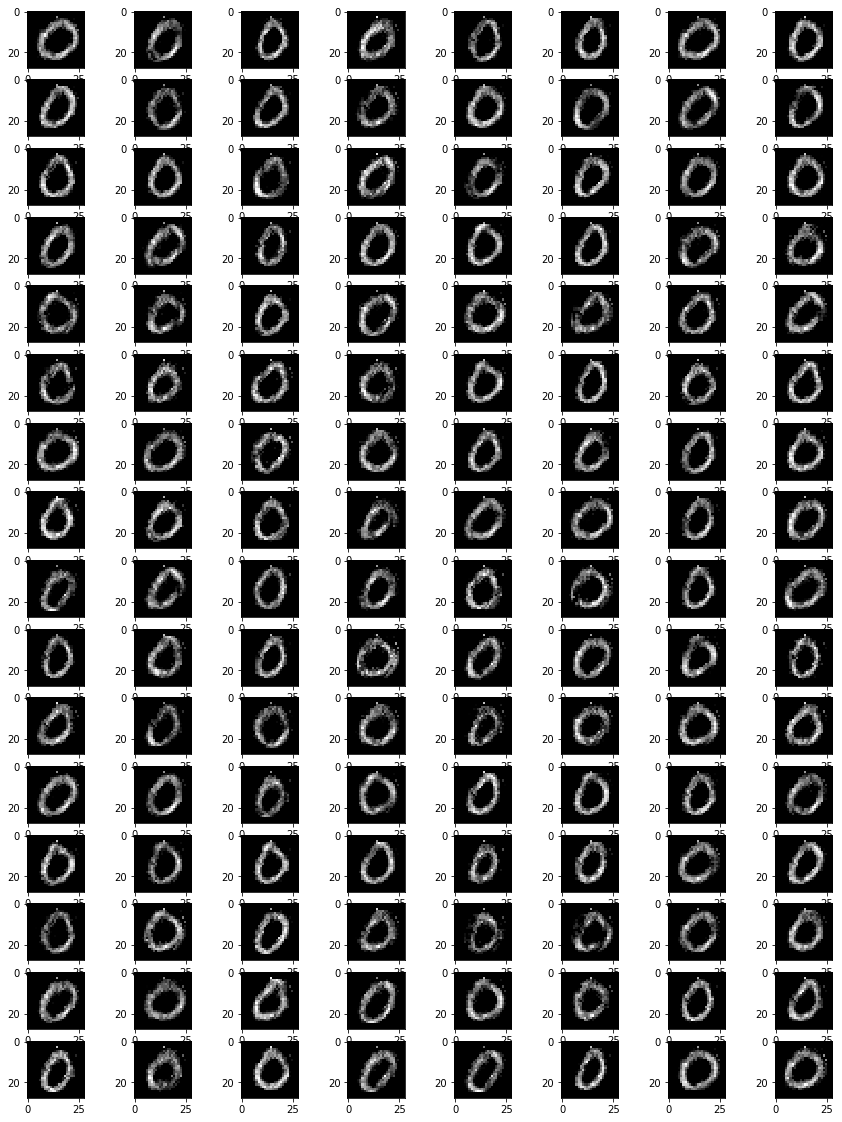

In [50]:
Noise_x = np.random.normal(loc=0, scale=1, size=(128, 100))
fake_image_flatten = model_G.predict(Noise_x)
fake_image = fake_image_flatten.reshape(fake_image_flatten.shape[0], 28, 28)

plt.figure(figsize=[15,20])
for i in range(128):
    plt.subplot(16,8,i + 1)
    plt.imshow(fake_image[i], cmap='gray')
plt.show()

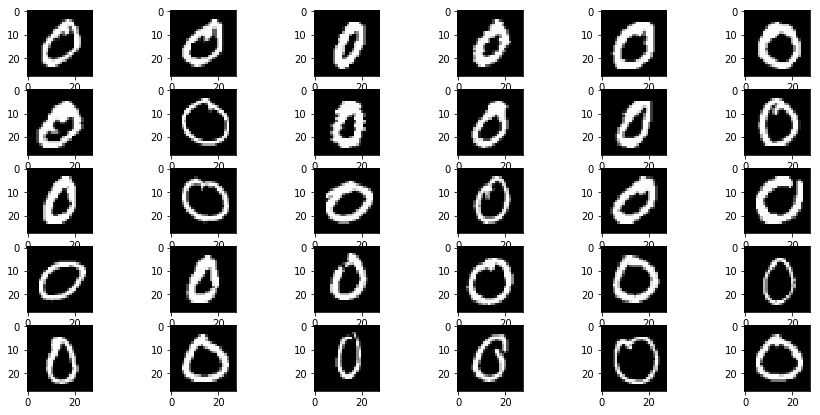

In [47]:
plt.figure(figsize=[15,7])
for i in range(30):
    plt.subplot(5,6,i + 1)
    plt.imshow(X_train.reshape(X_train.shape[0], 28,28)[i], cmap='gray')
plt.show()

In [4]:
help(tqdm.set_postfix)

Help on function set_postfix in module tqdm._tqdm:

set_postfix(self, ordered_dict=None, **kwargs)
    Set/modify postfix (additional stats)
    with automatic formatting based on datatype.

